In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as sma
import itertools
import datetime
import matplotlib
import pytest

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt, exp

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

sns.set_style('whitegrid')

import sys
sys.path.append('..')
from src.data.dataset_generator import DatasetGenerator
from src.data.data_transformer import DataTransformer

# 1. Reading in the Data from the API

Download the Data (Montel Data & Weather Data; Entsoe Data is still missing)

In [3]:
dg = DatasetGenerator(['all'])
dataset_latest = dg.get_dataset('2018-01-01', 'latest', 'ignored')

Repaired missing entsoe data from dates: ['2021-08-21' '2021-08-22']
Data coverage 100%
Data coverage 100%
Data coverage 100%
Data coverage 100%


# 2. Data Preprocessing

Set datetime as index of the dataframe and display the length and timerange of the downloaded dataset.

In [4]:
# Extract Length, and Timerange of the Downloaded Dataset
X = dataset_latest.Time

datapoints = X.index.max()
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))

# Change Index from Dataframe (new index: Time)
data_hourly = dataset_latest.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')

Number of datapoints in the Dataset: 31919
Minimum date from data set: 2018-01-01 00:00:00
Maximum date from data set: 2021-08-22 23:00:00


## 2.1 Display Data Characteristics

In [8]:
data_hourly

,SPOTPrice,Load,Solar,Wind Offshore,Wind Onshore,temp_muc,dwpt_muc,rhum_muc,prcp_muc,wspd_muc,pres_muc,tsun_muc,temp_ham,dwpt_ham,rhum_ham,prcp_ham,wspd_ham,pres_ham,tsun_ham
2018-01-01 00:00:00,-5.27,51511.00,0.0,2917.50,29575.00,5.5,1.2,74.0,0.0,10.4,1009.5,0.0,8.2,7.8,97.0,0.3,13.0,993.8,0.0
2018-01-01 01:00:00,-29.99,50191.25,0.0,2999.25,30938.25,7.9,0.6,60.0,0.0,14.0,1008.9,0.0,8.7,7.6,93.0,0.1,19.4,993.3,0.0
2018-01-01 02:00:00,-56.65,48959.50,0.0,3096.00,31699.25,7.8,0.7,61.0,0.0,13.3,1008.7,0.0,8.3,6.4,88.0,0.0,24.8,994.1,0.0
2018-01-01 03:00:00,-63.14,47927.00,0.0,3136.75,32333.00,7.9,1.5,64.0,0.0,14.8,1009.1,0.0,8.1,6.4,89.0,0.0,22.7,993.9,0.0
2018-01-01 04:00:00,-64.62,47790.00,0.0,3212.00,31982.25,8.3,2.9,69.0,0.0,16.6,1010.1,0.0,8.1,5.9,86.0,0.0,24.1,993.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 19:00:00,95.00,50750.75,26536.5,102.00,361.75,20.8,15.6,72.0,0.9,13.0,1017.4,60.0,18.9,14.6,76.0,0.5,14.8,1016.3,9.0
2021-08-22 20:00:00,97.96,50750.75,26536.5,102.00,361.75,20.8,15.6,72.0,0.9,13.0,1017.4,60.0,18.9,14.6,76.0,0.5,14.8,1016.3,9.0
2021-08-22 21:00:00,95.48,50750.75,26536.5,102.00,361.75,20.8,15.6,72.0,0.9,13.0,1017.4,60.0,18.9,14.6,76.0,0.5,14.8,1016.3,9.0
2021-08-22 22:00:00,90.10,50750.75,26536.5,102.00,361.75,20.8,15.6,72.0,0.9,13.0,1017.4,60.0,18.9,14.6,76.0,0.5,14.8,1016.3,9.0


In [6]:
data_hourly.describe()

,SPOTPrice,Load,Solar,Wind Offshore,Wind Onshore,temp_muc,dwpt_muc,rhum_muc,prcp_muc,wspd_muc,pres_muc,tsun_muc,temp_ham,dwpt_ham,rhum_ham,prcp_ham,wspd_ham,pres_ham,tsun_ham
count,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000,31920.000000
mean,41.842852,58556.786756,5194.528102,2631.569149,10995.259555,11.009746,5.173838,70.619486,0.115639,10.061526,1016.890724,14.657143,10.602873,6.105858,76.280576,0.075504,14.771203,1014.834577,12.524185
std,21.199202,10984.170290,7816.799828,1818.435005,8703.435419,8.264561,6.689020,18.743518,0.721259,5.697911,8.603000,23.440862,7.459952,6.101213,16.847288,0.448982,7.849705,10.162819,21.704746
min,-80.690000,0.000000,0.000000,0.000000,0.000000,-13.400000,-17.500000,15.000000,0.000000,0.000000,982.000000,0.000000,-13.800000,-18.100000,18.000000,0.000000,0.000000,978.000000,0.000000
25%,30.090000,49976.500000,0.000000,966.000000,4297.187500,4.400000,-0.100000,57.000000,0.000000,6.100000,1011.900000,0.000000,5.100000,1.700000,66.000000,0.000000,9.000000,1008.700000,0.000000
50%,40.720000,58122.250000,213.500000,2451.625000,8413.000000,10.900000,4.900000,74.000000,0.000000,8.600000,1017.000000,0.000000,10.100000,6.300000,80.000000,0.000000,13.700000,1015.600000,0.000000
75%,52.390000,66957.000000,8569.687500,4114.750000,15421.062500,17.100000,11.200000,87.000000,0.000000,12.200000,1021.800000,28.000000,15.900000,10.800000,90.000000,0.000000,19.400000,1021.300000,17.000000
max,200.040000,90809.500000,36175.250000,7126.250000,40987.250000,34.800000,20.300000,100.000000,37.500000,49.000000,1047.100000,60.000000,35.000000,21.600000,100.000000,38.700000,60.100000,1046.200000,60.000000


## 2.3 Extract each Feature from the Dataframe

Each Feature of the Dataframe is extracted as Pandas Series

In [9]:
data_spot = data_hourly.SPOTPrice
data_load = data_hourly.Load
data_solar = data_hourly.Solar
data_wind_off = data_hourly["Wind Offshore"]
data_wind_on = data_hourly["Wind Onshore"]
data_temp = data_hourly.temp_muc
data_dwpt = data_hourly.dwpt_muc
data_rhum = data_hourly.rhum_muc
data_prcp = data_hourly.prcp_muc
data_wspd = data_hourly.wspd_muc
data_pres = data_hourly.pres_muc
data_tsun = data_hourly.tsun_muc

## 2.4 Create Spotprice Datasets with different length (Final Week excluded)

For testing univariant spot price forecasting, subdivide the whole dataset into datasets with the following lengths \
(final week is excluded for the model evaluation; will be changed for a better quality in evaluation):
* previous 5 and 1 year/-s
* previous 6, 3 and 1 month/-s
* previous 3, 2 and 1 week/-s
* previous 5, 4, 3, 2 and 1 day/-s

In [18]:
# Training and Validation Sets for Model Training and Hyperparameter Tuning
df_all = data_spot.iloc[:-168]
df_3a = data_spot.iloc[-26472:-168]
df_2a = data_spot.iloc[-17712:-168]
df_1a = data_spot.iloc[-8928:-168]
df_6m = data_spot.iloc[-4512:-168]
df_3m = data_spot.iloc[-2304:-168]
df_1m = data_spot.iloc[-912:-168]
df_3w = data_spot.iloc[-672:-168]
df_2w = data_spot.iloc[-504:-168]
df_1w = data_spot.iloc[-336:-168]
df_5d = data_spot.iloc[-288:-168]
df_4d = data_spot.iloc[-264:-168]
df_3d = data_spot.iloc[-240:-168]
df_2d = data_spot.iloc[-216:-168]
df_1d = data_spot.iloc[-192:-168]

# 3. Baseline Models

## 3.1 Scoring Metrics

For model hyperparameter tuning the RMSE metric is used \
For the evaluation of the model, four metric are taken into account:
* root mean squared error (RMSE) --> Metric = rmse
* mean absolute error (MAE) --> Metric = mean_absolute_error
* mean absolute percentage error (MAPE) --> Metric = mape
* symmetric mean absolute percentage error (sMAPE) --> Metric = smape

In [19]:
def mape(y_true, y_pred):
    mape_score = abs((y_true-y_pred)/y_true)*100
    return np.mean(mape_score)
def smape(y_true, y_pred):
    smape_score = 200*abs((y_pred-y_true))/(y_true+y_pred)
    return np.mean(smape_score)
def rmse(y_true, y_pred):
    rmse_score = mean_squared_error(y_true,y_pred)
    return np.sqrt(rmse_score)

In the section below, the final datetime for the training set can be determined. For testing purposes, this was used as the final training value, in order to test the functionality for the baseline models. 

In [20]:
# Final Date for Training Set (Format: YEAR-MONTH-DAY XX:YY:ZZ)
# Prediction from this Timestamp: +1h; +24h; +168h
split_date = pd.Timestamp('2021-07-25 16:00:00')

## 3.1. Naive

This is the simplest model for prediction and used as a baseline model. This model uses the latest datavalue for all the following prediction values.

### 3.1.1 Naive Function for Visualisation

In [36]:
def vis_naive_model(data, pred_ind, metric):
    """
    Naive model forecasting for visualization purposes
    Every future prediction value is set to the latest value in the training set
    The final datetime value determines the end of the training set
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')

    # prepare prediciton indexes
    start = len(data.loc[:pred_ind])
    dti = data.index[start:]
    
    # pandas series with every prediction value set to latest training set value
    pred_naive = pd.Series(data=data.loc[pred_ind], index=dti)

    # scoring
    score = metric(pred_naive.values, data[start:].values)
    
    # plot input data and prediction values
    plt.figure(figsize=[17,10])
    plt.plot(data.loc[pred_ind:], 'b', label='Data')
    plt.plot(pred_naive.index, pred_naive, 'r', label='Prediction')
    plt.tick_params(axis='x',labelsize=30)
    plt.tick_params(axis='y',labelsize=30)
    plt.xticks(rotation=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Spot Price [€/MWh]', fontsize=30)
    plt.title('NAIVE: Data vs. Prediction', fontsize=40)
    plt.legend(fontsize=30)
    
    return pred_naive, score

Metric Score:	39.32687814483112


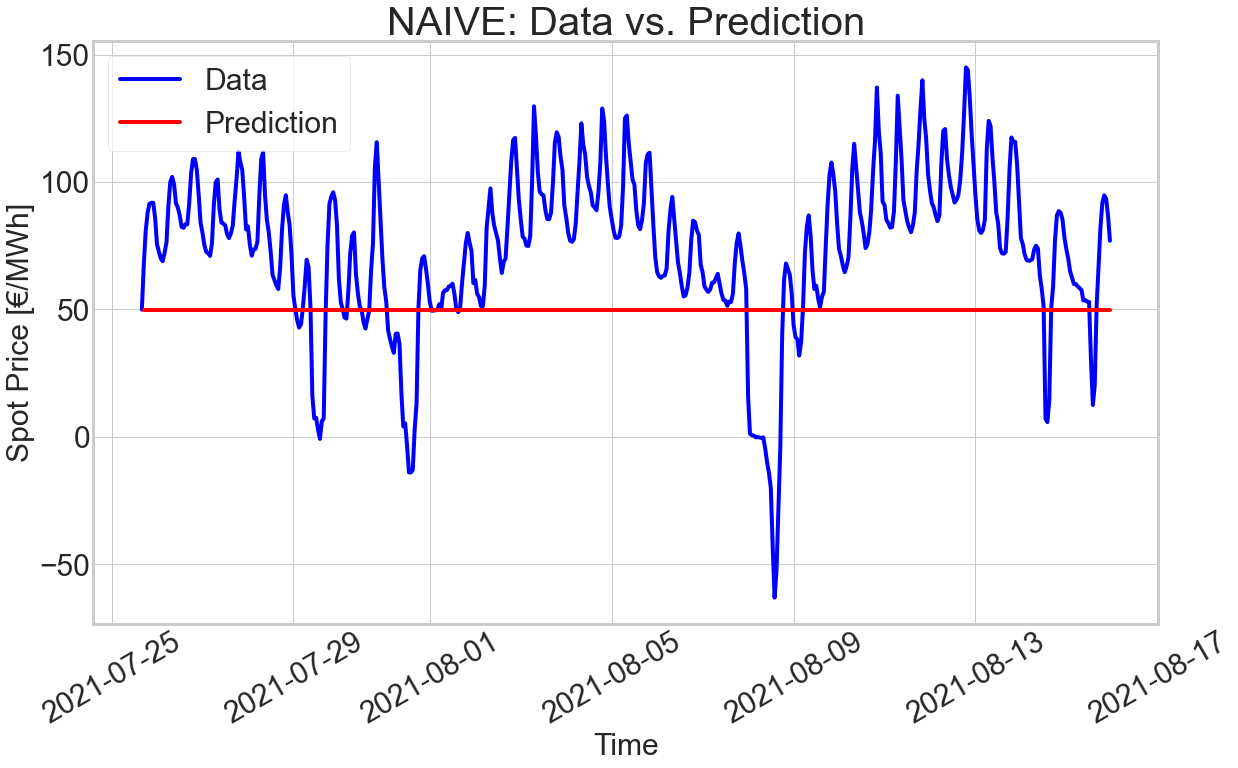

In [37]:
vis_naive, score_naive = vis_naive_model(df_1m,split_date, rmse)
print(f'Metric Score:\t{score_naive}')

### 3.1.2 Naive Function for Final Usage

To do: Add Metric

In [25]:
def naive_model(data, pred_ind):
    """
    Naive model forecasting for +1h, +24h, +168h
    All three future prediction values are set to the latest value in the training set
    The final datetime value determines the end of the training set
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing all three prediciton values
    """
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')

    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dt = data.index
    dti = pd.to_datetime([dt[n_idx],dt[n_idx+23],dt[n_idx+167]])
    
    # pandas series containing all three prediction values with latest value in training set
    pred_naive = pd.Series(data=data.loc[pred_ind], index=dti)
    
    return pred_naive

In [26]:
naive = naive_model(df_1m,split_date)
print(naive)

2021-07-25 17:00:00    49.91
2021-07-26 16:00:00    49.91
2021-08-01 16:00:00    49.91
dtype: float64


## 3.2 SNaive

Another simple baseline model, which predicts the datepoints of interest with the data from the previous year (seasonality). \
As it can be seen in the plot below, the performance of this model is very poor. This model uses the spot price values from the previous year. In order to improve the performance, a bias from the trend difference of both years can be added. This should eliminate the offset between the real data and the prediction. 

### 3.2.1 SNaive Function for Visualisation

In [42]:
def vis_snaive_model(data, pred_ind, metric):
    """
    SNaive model forecasting for visualization purposes
    Every future prediction value is set to the latest value of the previous seasonality in the training set
    The final datetime value determines the end of the train set
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # indexes for getting the values of the previous seasonality (here: previous year)
    date_1a_start = pred_ind - datetime.timedelta(days=365,hours=-1)
    date_1a_end = data.index[-1] - datetime.timedelta(days=365)
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')
    
    # checking if data from previous seasonality is available in the dataset
    elif (date_1a_start not in data.index):
        raise ValueError('Please ensure that the Dataframe contains Data from at least one Year ago.')
    
    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dti = data.index[n_idx:]
    
    # get the values of the previous seasonality
    da = data[date_1a_start:date_1a_end].values
    
    # pandas series containing all prediction values
    pred_snaive = pd.Series(data=da, index=dti)
    
    # scoring
    score = metric(pred_snaive.values, data[n_idx:].values)
    
    # plot input data and prediction values
    plt.figure(figsize=[17,10])
    plt.plot(data.loc[pred_ind:], 'b', label='Data')
    plt.plot(pred_snaive.index, pred_snaive, 'r', label='Prediction')
    plt.tick_params(axis='x',labelsize=30)
    plt.tick_params(axis='y',labelsize=30)
    plt.xticks(rotation=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Spot Price [€/MWh]', fontsize=30)
    plt.title('SNAIVE: Data vs. Prediction', fontsize=40)
    plt.legend(fontsize=30)
    
    return pred_snaive, score

Metric Score:	51.18767354639178


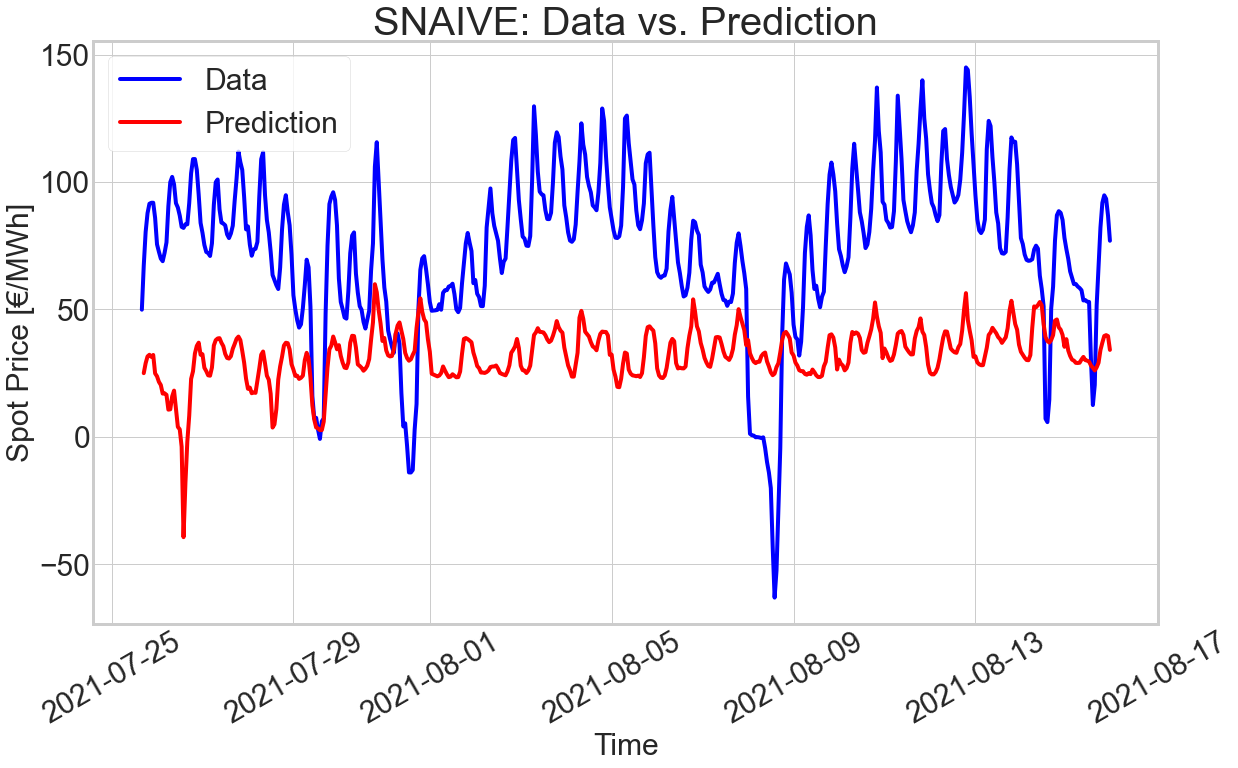

In [45]:
vis_snaive, score_snaive = vis_snaive_model(df_2a,split_date, rmse)
print(f'Metric Score:\t{score_snaive}')

### 3.2.2 SNaive Function for Final Usage

To do: Add Metric

In [46]:
def snaive_model(data, pred_ind):
    """
    SNaive model forecasting for visualization purposes
    Every future prediction value is set to the latest value of the previous seasonality in the training set
    The final datetime value determines the end of the train set
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # index for getting the values of the previous seasonality (here: previous year)
    date_1a = pred_ind - datetime.timedelta(days=365)
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')
    # checking if data from previous seasonality is available in the dataset
    elif (date_1a not in data.index):
        raise ValueError('Please ensure that the Dataframe contains Data from at least one Year ago.')
    
    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dt = data.index
    dti = pd.to_datetime([dt[n_idx],dt[n_idx+23],dt[n_idx+167]])
    
    # get predicition values from previous seasonality
    data = np.array([data.loc[date_1a+datetime.timedelta(hours=1)],data.loc[date_1a+datetime.timedelta(hours=24)],
                    data.loc[date_1a+datetime.timedelta(hours=168)]])
    
    # pandas series containing all three prediction values
    pred_snaive = pd.Series(data=data, index=dti)
    
    return pred_snaive

In [48]:
snaive = snaive_model(df_2a,split_date)
print(snaive)

2021-07-25 17:00:00    25.01
2021-07-26 16:00:00    -1.82
2021-08-01 16:00:00    25.65
dtype: float64


# 4. Valdiation and Evaluation Methods

## 4.1 Rolling Forecast (For Validation)

Rolling Forecast with an example gap of `gap=3`
* blue = train set
* red = validation set

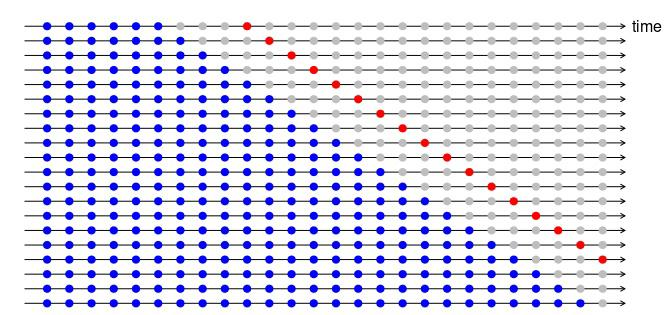

Rolling Foreccast with no gap

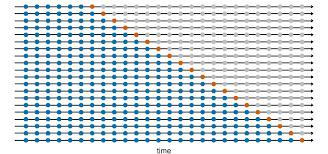

In [49]:
def rolling_forecast(data,min_train,gap):
    """
    Splitting the dataset with a rolling forecast validation method
    The first iteration returns a training dataset with min_train length and one validation set of length one
    After each iteration the training set is increased by the size of one sample
    Between the training set and the validation set is a gap for skipped values
    (+1h: gap=0; +24h: gap=23; +168h: gap = 167)
    
    :param data: pandas series or dataframe of the training and validation spotprice data
    :param min_train: length of the dataset for the first iteration
    :param gap: skipped values between training and validation set
    :yield split_train:
    :yield split_val:
    """
    
    for i in range(len(data)-min_train-gap):
        split_train = data[:min_train+i]
        split_val = data[min_train+i+gap:min_train+i+gap+1]
        yield split_train, split_val

For the project, there are three gaps of interest. Predicting +1h, +24 and +168h. Therefore we determine our min_train_size for cross validation. For Prediction of +1h, set `gap=0`; for prediction of +24h, set `gap=23`; for prediction of +168h set `gap=167`.

In [11]:
rolling_1h = rolling_forecast(df_1d, 10, gap=0)

In [ ]:
# Example for plotting the rolling forward method:
# i=0
# for cv_train,cv_val in rolling_1h:
#     print(f'CV[{i+1}]')
#     print(f'Train:\t{cv_train}')
#     print(f'Val:\t{cv_val}')
#     print('------')
#     i+=1

In [13]:
rolling_24h = rolling_forecast(df_5d,50,gap=23)

In [15]:
rolling_168h = rolling_forecast(df_2w,150,gap=167)

## 4.2 Sliding Window (For Evaluation)

For the project, there are three gaps of interest. Predicting +1h, +24 and +168h. Therefore we determine our min_train_size for cross validation. For Prediction of +1h, set `gap=0`; for prediction of +24h, set `gap=23`; for prediction of +168h set `gap=167`.

Sliding Window with not gap:
* black: training set
* pink: test set

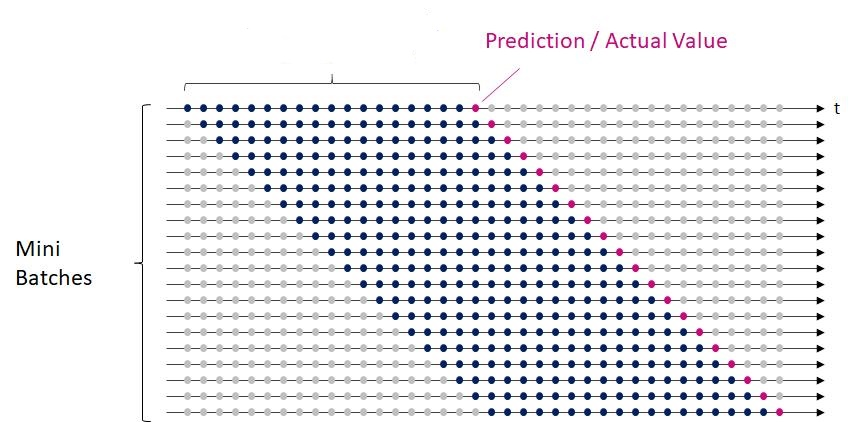

In [50]:
def sliding_window(data,window_size,gap):
    """
    Splitting the dataset with a sliding window evaluation method
    As a queue the training set and validation value are moving on one position after each iteration
    Between the training set and the validation set is a gap for skipped values
    (+1h: gap=0; +24h: gap=23; +168h: gap = 167)
    
    :param data: pandas series or dataframe for the training and validation spotprice data
    :param window_size: length of the training size
    :param gap: skipped values between training and validation set
    :yield split_train:
    :yield split_val:
    """
    
    for i in range(len(data)-window_size-gap):
        split_train = data[i:window_size+i]
        split_val = data[i+window_size+gap:i+window_size+gap+1]
        yield split_train, split_val

# 5. SARIMAX Model

## 5.1 Cross Validation Score

In [51]:
def sarimax_cross_validation_score(cv,gap,metric,par,seas_par):
    """
    Cross validation score for the SARIMAX model
    
    :param cv: cross validation method (here: rolling_forecast)
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :param par: tuple of parameter for the SARIMAX model in format (p,d,q)
    :param seas_par: tuple of seasonal parameter for the SARIMAX model in format (P,D,Q,S)
    :return cv_scores: returns a numpy array of the cross validation score for each iteration
    :return train_len: returns a numpy array of the train dataset length for each iteratiomn
    """
    
    cv_scores=[]
    train_len = []
    for cv_train,cv_val in cv:
        model = SARIMAX(cv_train,order=par,seasonal_order=seas_par)
        model_fit = model.fit(method='powell',disp=False)
        # replace horizon with gap
        preds = model_fit.predict(len(cv_train)+gap,len(cv_train)+gap)
        score = metric(y_true=cv_val, y_pred=preds)
        cv_scores.append(score)
        train_len.append(len(cv_train)-1)
    return np.array(cv_scores), np.array(train_len)

## 5.2 Hyperparameter Tuning 
#### Perform a GridSearch Tuning the Hyperparameter; Evaluate best Scoring to determine TimeWindow & Model Parameters

In [52]:
import warnings
warnings.filterwarnings('ignore')

Hyperparameters for the SARIMAX Model:
* SARIMAX Model Parameter: (p,d,q)
* SARIMAX Model Sesonal Parameter: (P,D,Q,S)
* Length of the Training Data

In [53]:
def hyperparameter_tuning(data,min_train,gap,metric,p_max,d_max,q_max):
    """
    Hyperparameter Tuning for the SARIMAX model
    
    :param data: pandas series or dataframe of the spotprice data
    :param min_train: length of the dataset for the first iteration
    :param gap:skipped values between training and validation set
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :param p_max: maximum p value (p-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended p_max = 3
    :param q_max: maximum q value (q-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended d_max = 3
    :param d_max: maximum d value (d-1) of the tuple (p,d,q) and (P,D,Q,S) --> recommended q_max = 2
    :return df: returns dataframe after hyperparemter tuning
    :return df_rank: returns ranked dataframe (depending on the scoring)
    """
    
    p = range(0,p_max)
    d = range(0,d_max)
    q = range(0,q_max)
    s = range(24,25)
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    
    columns = ['Parameter','SeasonalParameter','TrainLength','Score']
    df = pd.DataFrame(columns=columns)
    
    for param in pdq:
        for s_param in seasonal_pdq:
            if param[0] == s_param[0] and param[1] == s_param[1] and param[2] == s_param[2]:
                if gap==0:
                    cv_rolling_1h = rolling_forecast(data,min_train,gap=gap)
                    sc, idx = sarimax_cross_validation_score(cv_rolling_1h,gap,metric=metric,par=param,seas_par=s_param)
                elif gap==23:
                    cv_rolling_24h = rolling_forecast(data,min_train,gap=gap)
                    sc, idx = sarimax_cross_validation_score(cv_rolling_24h,gap,metric=metric,par=param,seas_par=s_param)
                elif gap==167:
                    cv_rolling_168h = rolling_forecast(data,min_train,gap=gap)
                    sc, idx = sarimax_cross_validation_score(cv_rolling_168h,gap,metric=metric,par=param,seas_par=s_param)
                
                min_score = np.min(sc)
                idx_min = np.argmin(sc)
                len_train = idx[idx_min]+1
                df.loc[len(df)] = [param,s_param,len_train,min_score]
    
    df_rank = df.sort_values(by=['Score'])
    
    return df, df_rank

### 5.2.1 Tuning +1h

#### 1. Root Mean Squared Error

In [55]:
df_mse, rank_mse = hyperparameter_tuning(df_1w,90,gap=0,metric=rmse,p_max=3,d_max=3,q_max=2)
print(rank_mse)

    Parameter SeasonalParameter TrainLength     Score
6   (1, 0, 0)     (1, 0, 0, 24)         165  0.002889
14  (2, 1, 0)     (2, 1, 0, 24)         153  0.016161
9   (1, 1, 1)     (1, 1, 1, 24)         122  0.019247
15  (2, 1, 1)     (2, 1, 1, 24)         113  0.021870
8   (1, 1, 0)     (1, 1, 0, 24)         153  0.024891
4   (0, 2, 0)     (0, 2, 0, 24)         125  0.030000
7   (1, 0, 1)     (1, 0, 1, 24)         165  0.043052
10  (1, 2, 0)     (1, 2, 0, 24)         147  0.055188
17  (2, 2, 1)     (2, 2, 1, 24)         146  0.057240
2   (0, 1, 0)     (0, 1, 0, 24)         149  0.100000
13  (2, 0, 1)     (2, 0, 1, 24)         123  0.103648
3   (0, 1, 1)     (0, 1, 1, 24)         167  0.121058
5   (0, 2, 1)     (0, 2, 1, 24)         108  0.262678
12  (2, 0, 0)     (2, 0, 0, 24)         149  0.276987
11  (1, 2, 1)     (1, 2, 1, 24)         146  0.315606
1   (0, 0, 1)     (0, 0, 1, 24)         143  0.710039
16  (2, 2, 0)     (2, 2, 0, 24)         122  0.998446
0   (0, 0, 0)     (0, 0, 0, 

In [59]:
rank_mse.to_pickle('rank_mse_1h.pkl')

#### 2. Mean Absolute Error

In [57]:
df_mae, rank_mae = hyperparameter_tuning(df_1w,min_train=90,gap=0,metric=mean_absolute_error,p_max=3,d_max=3,q_max=2)
print(rank_mae)

    Parameter SeasonalParameter TrainLength     Score
6   (1, 0, 0)     (1, 0, 0, 24)         165  0.002889
14  (2, 1, 0)     (2, 1, 0, 24)         153  0.016161
9   (1, 1, 1)     (1, 1, 1, 24)         122  0.019247
15  (2, 1, 1)     (2, 1, 1, 24)         113  0.021870
8   (1, 1, 0)     (1, 1, 0, 24)         153  0.024891
4   (0, 2, 0)     (0, 2, 0, 24)         125  0.030000
7   (1, 0, 1)     (1, 0, 1, 24)         165  0.043052
10  (1, 2, 0)     (1, 2, 0, 24)         147  0.055188
17  (2, 2, 1)     (2, 2, 1, 24)         146  0.057240
2   (0, 1, 0)     (0, 1, 0, 24)         149  0.100000
13  (2, 0, 1)     (2, 0, 1, 24)         123  0.103648
3   (0, 1, 1)     (0, 1, 1, 24)         167  0.121058
5   (0, 2, 1)     (0, 2, 1, 24)         108  0.262678
12  (2, 0, 0)     (2, 0, 0, 24)         149  0.276987
11  (1, 2, 1)     (1, 2, 1, 24)         146  0.315606
1   (0, 0, 1)     (0, 0, 1, 24)         143  0.710039
16  (2, 2, 0)     (2, 2, 0, 24)         122  0.998446
0   (0, 0, 0)     (0, 0, 0, 

In [60]:
rank_mae.to_pickle('rank_mae_1h.pkl')

#### 3. Mean Absolute Percentage Error (MAPE)

In [ ]:
df_mape, rank_mape = hyperparameter_tuning(df_1w,min_train=90,gap=0,metric=mape,p_max=3,d_max=3,q_max=2)
print(rank_mape)

In [ ]:
rank_mape.to_pickle('rank_mape_1h.pkl')

#### 4. Symmetric Mean Absolute Percentage Error (sMAPE)

In [ ]:
df_smape, rank_smape = hyperparameter_tuning(df_1w,min_train=90,gap=0,metric=smape,p_max=3,d_max=3,q_max=2)
print(rank_smape)

In [23]:
rank_smape.to_pickle('rank_smape_1h.pkl')

### 5.2.2 Tuning +24h

#### 1. Root Mean Squared Error

In [16]:
df_mse_24h, rank_mse_24h = hyperparameter_tuning(df_3w,min_train=90,gap=23,metric=rmse,p_max=3,d_max=3,q_max=2)
print(rank_mse_24h)

    Parameter SeasonalParameter TrainLength     Score
15  (2, 1, 1)     (2, 1, 1, 24)         176  0.002896
3   (0, 1, 1)     (0, 1, 1, 24)         177  0.008953
6   (1, 0, 0)     (1, 0, 0, 24)         104  0.011464
9   (1, 1, 1)     (1, 1, 1, 24)         292  0.013701
17  (2, 2, 1)     (2, 2, 1, 24)         230  0.014771
1   (0, 0, 1)     (0, 0, 1, 24)         321  0.018695
14  (2, 1, 0)     (2, 1, 0, 24)         411  0.030931
11  (1, 2, 1)     (1, 2, 1, 24)         214  0.045669
8   (1, 1, 0)     (1, 1, 0, 24)         194  0.045802
7   (1, 0, 1)     (1, 0, 1, 24)         337  0.063741
2   (0, 1, 0)     (0, 1, 0, 24)         142  0.080000
12  (2, 0, 0)     (2, 0, 0, 24)         208  0.163123
4   (0, 2, 0)     (0, 2, 0, 24)         277  0.170000
13  (2, 0, 1)     (2, 0, 1, 24)         344  0.177972
16  (2, 2, 0)     (2, 2, 0, 24)         267  0.280992
10  (1, 2, 0)     (1, 2, 0, 24)         138  0.488160
0   (0, 0, 0)     (0, 0, 0, 24)         327  0.780000
5   (0, 2, 1)     (0, 2, 1, 

In [24]:
rank_mse_24h.to_pickle('rank_mse_24h.pkl')

#### 2. Mean Absolute Error

In [17]:
df_mae_24h, rank_mae_24h = hyperparameter_tuning(df_3w,min_train=90,gap=23,metric=mean_absolute_error,p_max=3,d_max=3,q_max=2)
print(rank_mae_24h)

    Parameter SeasonalParameter TrainLength     Score
15  (2, 1, 1)     (2, 1, 1, 24)         176  0.002896
3   (0, 1, 1)     (0, 1, 1, 24)         177  0.008953
6   (1, 0, 0)     (1, 0, 0, 24)         104  0.011464
9   (1, 1, 1)     (1, 1, 1, 24)         292  0.013701
17  (2, 2, 1)     (2, 2, 1, 24)         230  0.014771
1   (0, 0, 1)     (0, 0, 1, 24)         321  0.018695
14  (2, 1, 0)     (2, 1, 0, 24)         411  0.030931
11  (1, 2, 1)     (1, 2, 1, 24)         214  0.045669
8   (1, 1, 0)     (1, 1, 0, 24)         194  0.045802
7   (1, 0, 1)     (1, 0, 1, 24)         337  0.063741
2   (0, 1, 0)     (0, 1, 0, 24)         142  0.080000
12  (2, 0, 0)     (2, 0, 0, 24)         208  0.163123
4   (0, 2, 0)     (0, 2, 0, 24)         277  0.170000
13  (2, 0, 1)     (2, 0, 1, 24)         344  0.177972
16  (2, 2, 0)     (2, 2, 0, 24)         267  0.280992
10  (1, 2, 0)     (1, 2, 0, 24)         138  0.488160
0   (0, 0, 0)     (0, 0, 0, 24)         327  0.780000
5   (0, 2, 1)     (0, 2, 1, 

In [25]:
rank_mae_24h.to_pickle('rank_mae_24h.pkl')

#### 3. Mean Absolute Percentage Error (MAPE)

In [18]:
df_mape_24h, rank_mape_24h = hyperparameter_tuning(df_3w,min_train=90,gap=23,metric=mape,p_max=3,d_max=3,q_max=2)
print(rank_mape_24h)

    Parameter SeasonalParameter TrainLength       Score
15  (2, 1, 1)     (2, 1, 1, 24)         176    0.002741
3   (0, 1, 1)     (0, 1, 1, 24)         177    0.008374
6   (1, 0, 0)     (1, 0, 0, 24)         104    0.009982
9   (1, 1, 1)     (1, 1, 1, 24)         292    0.018643
1   (0, 0, 1)     (0, 0, 1, 24)         321    0.028109
17  (2, 2, 1)     (2, 2, 1, 24)         230    0.030418
11  (1, 2, 1)     (1, 2, 1, 24)         214    0.052493
14  (2, 1, 0)     (2, 1, 0, 24)         411    0.056402
8   (1, 1, 0)     (1, 1, 0, 24)         194    0.056954
2   (0, 1, 0)     (0, 1, 0, 24)         142    0.072727
7   (1, 0, 1)     (1, 0, 1, 24)         300    0.098562
4   (0, 2, 0)     (0, 2, 0, 24)         277    0.204819
13  (2, 0, 1)     (2, 0, 1, 24)         344    0.225309
16  (2, 2, 0)     (2, 2, 0, 24)         465    0.231808
12  (2, 0, 0)     (2, 0, 0, 24)         208    0.250920
10  (1, 2, 0)     (1, 2, 0, 24)         138    0.538036
5   (0, 2, 1)     (0, 2, 1, 24)         446    0

In [26]:
rank_mape_24h.to_pickle('rank_mape_24h.pkl')

#### 4. Symmetric Mean Absolute Percentage Error (sMAPE)

In [ ]:
df_smape_24h, rank_smape_24h = hyperparameter_tuning(df_3w,min_train=90,gap=23,metric=smape,p_max=3,d_max=3,q_max=2)
print(rank_mape_24h)

In [ ]:
rank_smape_24h.to_pickle('rank_smape_24h.pkl')

### 5.2.3 Tuning +168h

#### 1. Root Mean Squared Error

In [ ]:
df_mse_168h, rank_mse_168h = hyperparameter_tuning(df_3w,min_train=90,gap=167,rmse,3,3,2)
print(rank_168h)

In [ ]:
rank_mse_168h.to_pickle('rank_mse_168h.pkl')

#### 2. Mean Absolute Error

In [ ]:
df_mae_168h, rank_mae_168h = hyperparameter_tuning(df_3w,min_train=90,gap=167,mean_absolute_error,3,3,2)
print(rank_mae_168h)

In [ ]:
rank_mae_168h.to_pickle('rank_mae_168h.pkl')

#### 3. Mean Absolute Percentage Error (MAPE)

In [ ]:
df_mape_168h, rank_mape_168h = hyperparameter_tuning(df_3w,min_train=90,gap=167,mape,3,3,2)
print(best_mape_168h)

In [ ]:
rank_mape_168h.to_pickle('rank_mape_168h.pkl')

#### 4. Symmetric Mean Absolute Percentage Error (sMAPE)

In [ ]:
df_smape_168h, rank_smape_168h = hyperparameter_tuning(df_3w,min_train=90,gap=167,smape,3,3,2)
print(rank_mape_168h)

In [ ]:
rank_smape_168h.to_pickle('rank_smape_168h.pkl')

Missing in Code above: 
* Include Visualization for Results of different Metrics, Timelengths and Score

## 5.3 Walk Forward Evaluation

* After Hyperparameter Tuning the function returns a ranked dataframe with the best hyperparameters at first.
* These are used for the evaluation of the model.
* In this section a walk forward evaluation is performed. From the hyperparameter data length a sliding window is generated. 
* In each iteration one value is predicted, based on fitting the model to the input data of the optimal length. 
* This process is done until the end of the Time Series is reached. 

In [136]:
# from the ranked hyperparameter tuning the first row contains the hyperparameter with the best results
best_train = rank_smape.iloc[0]
print(best_train)
# load .pkl file back to workspace

Parameter                (0, 2, 0)
SeasonalParameter    (0, 2, 0, 24)
TrainLength                    140
Score                          0.0
Name: 4, dtype: object


In [162]:
def walk_forward_evaluation(data, rank_train, gap, metric):
    """
    Walk Forward Evaluation after cross validation
    
    :param data: pandas series or dataframe of the spotprice data (recommended: the whole dataset)
    :param rank_train: ranked hyperparameter of the model training (all model params with best data length --> min score)
    :param gap: skipped values between training and validation set
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :return preds: returns a numpy array with the prediction values for the spot price
    :return score_list: returns a list with float values for the score during evaluation
    :return plt_data: returns the preprocessed dataset for the plotting
    :return window: returns the datalength from hyperparameter tuning for plotting
    """
    
    # check if data contains more samples than the minimum training length
    if len(data) <= opt_len:
        return ValueError('Please ensure that the Dataset contains of more samples.')
    
    # extract the best hyperparameters from the ranked dataframe from the tuning process
    best = rank_train.iloc[0]
    window = best.TrainLength
    params = best.Parameter
    s_params = best.SeasonalParameter
    
    # preprocess the data for 
    plt_data = data[-169-window:]
    
    sl_window = sliding_window(plt_data, window, gap=gap)
    
    preds = np.array([])
    score_list = []
    
    for cv_train,cv_eval in sl_window:
        print(f'Train:\t{cv_train}')
        print(f'Val:\t{cv_eval}')
        print('-----------------')
        
        # Model and Fitting
        model = SARIMAX(cv_train, order=params, seasonal_order=s_params)
        model_fit = model.fit(method='powell',disp=False)
        
        # Forecast daily loads for week i
        forecast = model_fit.predict(len(cv_train)+gap,len(cv_train)+gap)
        print('Predicted Value: {}'.format(forecast))
        preds = np.concatenate((preds, forecast),axis=None)
        
        # Scoring
        score = metric(y_true=cv_eval, y_pred=forecast)
        print('Score: {}'.format(score))
        score_list.append(score)
        print('--------------')
    
    return preds, score_list, plt_data, window

In [150]:
pred, sc, opt_d, opt_len = walk_forward_evaluation(data_spot,rank_smape,0,mean_absolute_error)

Train:	2021-07-30 03:00:00     46.86
2021-07-30 04:00:00     46.39
2021-07-30 05:00:00     57.17
2021-07-30 06:00:00     72.10
2021-07-30 07:00:00     78.99
                        ...  
2021-08-04 18:00:00    107.46
2021-08-04 19:00:00    128.83
2021-08-04 20:00:00    123.92
2021-08-04 21:00:00    110.09
2021-08-04 22:00:00     99.22
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-04 23:00:00    90.03
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-04 23:00:00    70.14
Freq: H, dtype: float64
Score: 19.88999999999882
--------------
Train:	2021-07-30 04:00:00     46.39
2021-07-30 05:00:00     57.17
2021-07-30 06:00:00     72.10
2021-07-30 07:00:00     78.99
2021-07-30 08:00:00     80.23
                        ...  
2021-08-04 19:00:00    128.83
2021-08-04 20:00:00    123.92
2021-08-04 21:00:00    110.09
2021-08-04 22:00:00     99.22
2021-08-04 23:00:00     90.03
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-05

Predicted Value: 2021-08-05 13:00:00    104.43
Freq: H, dtype: float64
Score: 15.640000000002061
--------------
Train:	2021-07-30 18:00:00     75.93
2021-07-30 19:00:00    106.00
2021-07-30 20:00:00    115.60
2021-07-30 21:00:00    100.21
2021-07-30 22:00:00     84.90
                        ...  
2021-08-05 09:00:00    115.28
2021-08-05 10:00:00    108.14
2021-08-05 11:00:00    101.00
2021-08-05 12:00:00     99.00
2021-08-05 13:00:00     88.79
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-05 14:00:00    82.99
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-05 14:00:00    71.13
Freq: H, dtype: float64
Score: 11.859999999996148
--------------
Train:	2021-07-30 19:00:00    106.00
2021-07-30 20:00:00    115.60
2021-07-30 21:00:00    100.21
2021-07-30 22:00:00     84.90
2021-07-30 23:00:00     69.62
                        ...  
2021-08-05 10:00:00    108.14
2021-08-05 11:00:00    101.00
2021-08-05 12:00:00     99.00
2021-08-05 13:00

Predicted Value: 2021-08-06 03:00:00    64.52
Freq: H, dtype: float64
Score: 1.3399999999999537
--------------
Train:	2021-07-31 08:00:00    36.50
2021-07-31 09:00:00    17.19
2021-07-31 10:00:00     4.12
2021-07-31 11:00:00     5.34
2021-07-31 12:00:00    -3.54
                       ...  
2021-08-05 23:00:00    70.60
2021-08-06 00:00:00    64.61
2021-08-06 01:00:00    63.01
2021-08-06 02:00:00    62.42
2021-08-06 03:00:00    63.18
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-06 04:00:00    63.31
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-06 04:00:00    64.07
Freq: H, dtype: float64
Score: 0.7600000000002751
--------------
Train:	2021-07-31 09:00:00    17.19
2021-07-31 10:00:00     4.12
2021-07-31 11:00:00     5.34
2021-07-31 12:00:00    -3.54
2021-07-31 13:00:00   -13.92
                       ...  
2021-08-06 00:00:00    64.61
2021-08-06 01:00:00    63.01
2021-08-06 02:00:00    62.42
2021-08-06 03:00:00    63.18
2021-08-

Predicted Value: 2021-08-06 18:00:00    84.12
Freq: H, dtype: float64
Score: 6.76000000000036
--------------
Train:	2021-07-31 23:00:00    59.88
2021-08-01 00:00:00    52.96
2021-08-01 01:00:00    49.49
2021-08-01 02:00:00    49.56
2021-08-01 03:00:00    49.66
                       ...  
2021-08-06 14:00:00    55.08
2021-08-06 15:00:00    55.56
2021-08-06 16:00:00    58.55
2021-08-06 17:00:00    64.41
2021-08-06 18:00:00    77.36
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-06 19:00:00    84.81
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-06 19:00:00    55.83
Freq: H, dtype: float64
Score: 28.980000000001816
--------------
Train:	2021-08-01 00:00:00    52.96
2021-08-01 01:00:00    49.49
2021-08-01 02:00:00    49.56
2021-08-01 03:00:00    49.66
2021-08-01 04:00:00    49.82
                       ...  
2021-08-06 15:00:00    55.56
2021-08-06 16:00:00    58.55
2021-08-06 17:00:00    64.41
2021-08-06 18:00:00    77.36
2021-08-06

Predicted Value: 2021-08-07 09:00:00    49.71
Freq: H, dtype: float64
Score: 10.189999999993006
--------------
Train:	2021-08-01 14:00:00    50.06
2021-08-01 15:00:00    48.94
2021-08-01 16:00:00    50.61
2021-08-01 17:00:00    60.29
2021-08-01 18:00:00    68.31
                       ...  
2021-08-07 05:00:00    60.51
2021-08-07 06:00:00    60.56
2021-08-07 07:00:00    62.31
2021-08-07 08:00:00    63.99
2021-08-07 09:00:00    59.90
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-07 10:00:00    56.14
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-07 10:00:00    52.89
Freq: H, dtype: float64
Score: 3.2499999999990266
--------------
Train:	2021-08-01 15:00:00    48.94
2021-08-01 16:00:00    50.61
2021-08-01 17:00:00    60.29
2021-08-01 18:00:00    68.31
2021-08-01 19:00:00    75.96
                       ...  
2021-08-07 06:00:00    60.56
2021-08-07 07:00:00    62.31
2021-08-07 08:00:00    63.99
2021-08-07 09:00:00    59.90
2021-08-

Predicted Value: 2021-08-08    62.74
Freq: H, dtype: float64
Score: 46.899999999996396
--------------
Train:	2021-08-02 05:00:00    59.30
2021-08-02 06:00:00    82.18
2021-08-02 07:00:00    89.92
2021-08-02 08:00:00    97.47
2021-08-02 09:00:00    87.74
                       ...  
2021-08-07 20:00:00    74.90
2021-08-07 21:00:00    69.00
2021-08-07 22:00:00    64.19
2021-08-07 23:00:00    58.02
2021-08-08 00:00:00    15.84
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-08 01:00:00    1.25
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-08 01:00:00   -35.67
Freq: H, dtype: float64
Score: 36.91999999999957
--------------
Train:	2021-08-02 06:00:00    82.18
2021-08-02 07:00:00    89.92
2021-08-02 08:00:00    97.47
2021-08-02 09:00:00    87.74
2021-08-02 10:00:00    82.80
                       ...  
2021-08-07 21:00:00    69.00
2021-08-07 22:00:00    64.19
2021-08-07 23:00:00    58.02
2021-08-08 00:00:00    15.84
2021-08-08 01:00:00

Predicted Value: 2021-08-08 15:00:00   -90.91
Freq: H, dtype: float64
Score: 38.479999999998704
--------------
Train:	2021-08-02 20:00:00    116.46
2021-08-02 21:00:00    117.28
2021-08-02 22:00:00    104.97
2021-08-02 23:00:00     92.91
2021-08-03 00:00:00     85.42
                        ...  
2021-08-08 11:00:00    -14.00
2021-08-08 12:00:00    -20.06
2021-08-08 13:00:00    -43.30
2021-08-08 14:00:00    -63.03
2021-08-08 15:00:00    -52.43
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-08 16:00:00   -28.6
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-08 16:00:00   -37.34
Freq: H, dtype: float64
Score: 8.740000000001828
--------------
Train:	2021-08-02 21:00:00    117.28
2021-08-02 22:00:00    104.97
2021-08-02 23:00:00     92.91
2021-08-03 00:00:00     85.42
2021-08-03 01:00:00     78.59
                        ...  
2021-08-08 12:00:00    -20.06
2021-08-08 13:00:00    -43.30
2021-08-08 14:00:00    -63.03
2021-08-08 15:00:00

Predicted Value: 2021-08-09 05:00:00    42.42
Freq: H, dtype: float64
Score: 8.439999999998264
--------------
Train:	2021-08-03 10:00:00    96.23
2021-08-03 11:00:00    95.21
2021-08-03 12:00:00    94.79
2021-08-03 13:00:00    88.96
2021-08-03 14:00:00    85.48
                       ...  
2021-08-09 01:00:00    39.20
2021-08-09 02:00:00    38.27
2021-08-09 03:00:00    31.92
2021-08-09 04:00:00    37.33
2021-08-09 05:00:00    50.86
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-09 06:00:00    72.21
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-09 06:00:00    66.65
Freq: H, dtype: float64
Score: 5.5600000000023755
--------------
Train:	2021-08-03 11:00:00    95.21
2021-08-03 12:00:00    94.79
2021-08-03 13:00:00    88.96
2021-08-03 14:00:00    85.48
2021-08-03 15:00:00    85.42
                       ...  
2021-08-09 02:00:00    38.27
2021-08-09 03:00:00    31.92
2021-08-09 04:00:00    37.33
2021-08-09 05:00:00    50.86
2021-08-0

Predicted Value: 2021-08-09 19:00:00    66.26
Freq: H, dtype: float64
Score: 36.64999999999412
--------------
Train:	2021-08-04 00:00:00     86.10
2021-08-04 01:00:00     80.23
2021-08-04 02:00:00     77.02
2021-08-04 03:00:00     76.54
2021-08-04 04:00:00     77.51
                        ...  
2021-08-09 15:00:00     54.97
2021-08-09 16:00:00     56.95
2021-08-09 17:00:00     74.96
2021-08-09 18:00:00     91.37
2021-08-09 19:00:00    102.91
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-09 20:00:00    107.61
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-09 20:00:00    92.39
Freq: H, dtype: float64
Score: 15.220000000011964
--------------
Train:	2021-08-04 01:00:00     80.23
2021-08-04 02:00:00     77.02
2021-08-04 03:00:00     76.54
2021-08-04 04:00:00     77.51
2021-08-04 05:00:00     83.30
                        ...  
2021-08-09 16:00:00     56.95
2021-08-09 17:00:00     74.96
2021-08-09 18:00:00     91.37
2021-08-09 19:00:

Predicted Value: 2021-08-10 09:00:00    104.68
Freq: H, dtype: float64
Score: 1.669999999999817
--------------
Train:	2021-08-04 14:00:00     90.83
2021-08-04 15:00:00     90.02
2021-08-04 16:00:00     88.91
2021-08-04 17:00:00     95.97
2021-08-04 18:00:00    107.46
                        ...  
2021-08-10 05:00:00     70.47
2021-08-10 06:00:00     85.96
2021-08-10 07:00:00    105.23
2021-08-10 08:00:00    115.00
2021-08-10 09:00:00    106.35
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-10 10:00:00    97.28
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-10 10:00:00    87.25
Freq: H, dtype: float64
Score: 10.030000000000072
--------------
Train:	2021-08-04 15:00:00     90.02
2021-08-04 16:00:00     88.91
2021-08-04 17:00:00     95.97
2021-08-04 18:00:00    107.46
2021-08-04 19:00:00    128.83
                        ...  
2021-08-10 06:00:00     85.96
2021-08-10 07:00:00    105.23
2021-08-10 08:00:00    115.00
2021-08-10 09:00:

Predicted Value: 2021-08-10 23:00:00    96.12
Freq: H, dtype: float64
Score: 3.869999999999905
--------------
Train:	2021-08-05 04:00:00     78.68
2021-08-05 05:00:00     82.89
2021-08-05 06:00:00     98.02
2021-08-05 07:00:00    124.94
2021-08-05 08:00:00    126.06
                        ...  
2021-08-10 19:00:00    116.29
2021-08-10 20:00:00    137.06
2021-08-10 21:00:00    120.00
2021-08-10 22:00:00    111.60
2021-08-10 23:00:00     92.25
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-11    91.07
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-11    83.67
Freq: H, dtype: float64
Score: 7.4000000000008725
--------------
Train:	2021-08-05 05:00:00     82.89
2021-08-05 06:00:00     98.02
2021-08-05 07:00:00    124.94
2021-08-05 08:00:00    126.06
2021-08-05 09:00:00    115.28
                        ...  
2021-08-10 20:00:00    137.06
2021-08-10 21:00:00    120.00
2021-08-10 22:00:00    111.60
2021-08-10 23:00:00     92.25
2021-0

Predicted Value: 2021-08-11 13:00:00    84.61
Freq: H, dtype: float64
Score: 2.400000000002933
--------------
Train:	2021-08-05 18:00:00    107.36
2021-08-05 19:00:00    110.83
2021-08-05 20:00:00    111.48
2021-08-05 21:00:00     97.05
2021-08-05 22:00:00     83.00
                        ...  
2021-08-11 09:00:00    108.98
2021-08-11 10:00:00     92.97
2021-08-11 11:00:00     88.63
2021-08-11 12:00:00     84.60
2021-08-11 13:00:00     82.21
Freq: H, Name: SPOTPrice, Length: 140, dtype: float64
Val:	2021-08-11 14:00:00    80.29
Freq: H, Name: SPOTPrice, dtype: float64
-----------------
Predicted Value: 2021-08-11 14:00:00    75.83
Freq: H, dtype: float64
Score: 4.459999999999411
--------------
Train:	2021-08-05 19:00:00    110.83
2021-08-05 20:00:00    111.48
2021-08-05 21:00:00     97.05
2021-08-05 22:00:00     83.00
2021-08-05 23:00:00     70.60
                        ...  
2021-08-11 10:00:00     92.97
2021-08-11 11:00:00     88.63
2021-08-11 12:00:00     84.60
2021-08-11 13:00:00

### Visualize Walk Forward Evaluation

In [159]:
def plot_walk_forward_evaluation(data,pred,window):
    """
    Plotting
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred: numpy array with the prediction values from the evaluation
    :param window: window for sliding window evaluation
    """
    
    plt.figure(figsize=[17,10])
    plt.plot(data[window:], 'b', label='Data')
    plt.plot(data.index[window:], pred, 'r', label='Prediction')
    plt.tick_params(axis='x',labelsize=30)
    plt.tick_params(axis='y',labelsize=30)
    plt.xticks(rotation=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Spot Price [€/MWh]', fontsize=30)
    plt.title('SARIMAX: Data vs. Prediction', fontsize=40)
    plt.legend(fontsize=30)

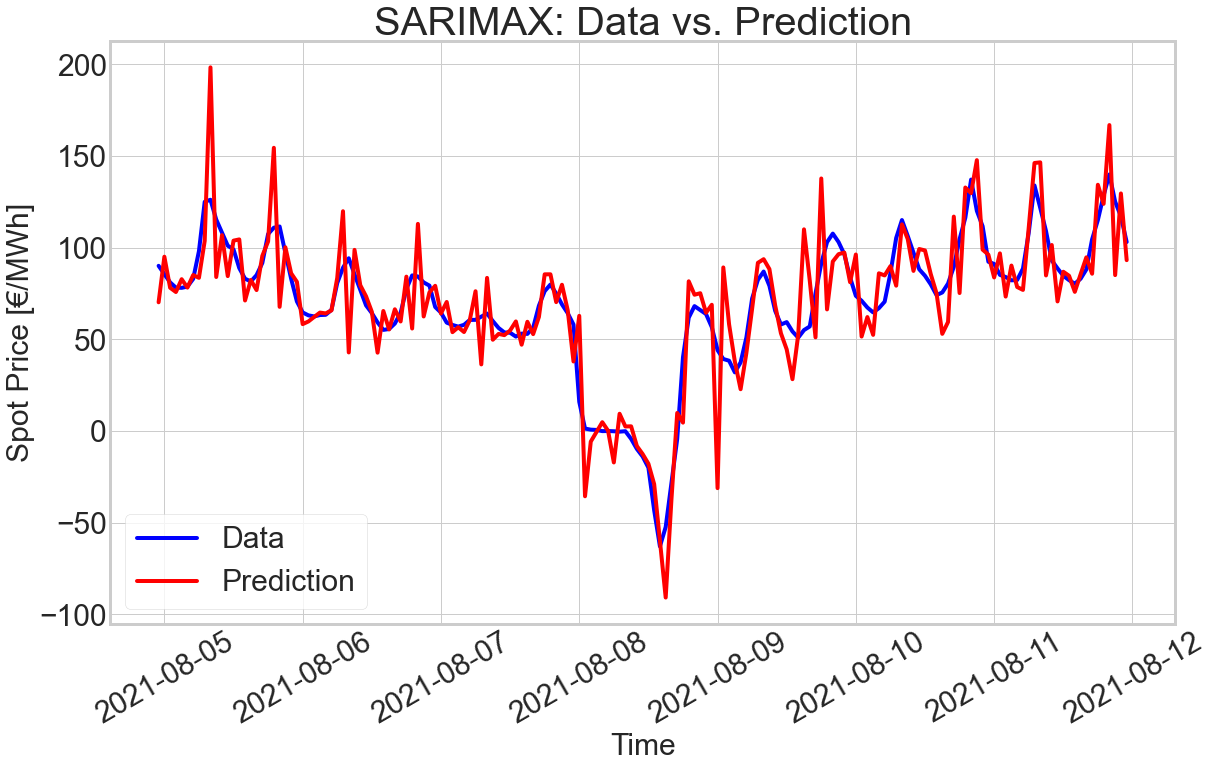

In [180]:
plot_walk_forward_evaluation(opt_d, pred, opt_len)

In [ ]:
def plot_walk_forward_evaluation_score(data,pred,window,score):
    """
    Plotting
    
    :param data: pandas series or dataframe of the spotprice data
    :param pred: numpy array with the prediction values from the evaluation
    :param window: window for sliding window evaluation
    :param score: list of evaluation score
    """
    
    plt.figure(figsize=[17,10])
    plt.plot(data[window:], 'b', label='Data')
    plt.plot(data.index[window:], pred, 'r', label='Prediction')
    plt.plot(data.index[window:], score, 'c', label='Score')
    plt.tick_params(axis='x',labelsize=30)
    plt.tick_params(axis='y',labelsize=30)
    plt.xticks(rotation=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Spot Price [€/MWh]', fontsize=30)
    plt.title('SARIMAX: Data vs. Prediction', fontsize=40)
    plt.legend(fontsize=30)

To do's:
* Functions into .py files
* Compare Performance to ARIMA Model with Seasonal Decomposition
* Include Exogenous Datasets (All features; Most important features etc.) and comparison with other Models
* Include further simple Models such as Vector-ARIMA, Linear Regression etc.